In [33]:
#Step 1: Install Required Libraries
!pip install torch torchvision torchaudio datasets transformers scikit-learn numpy matplotlib seaborn


In [14]:
#Step 2: Import Necessary Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from datasets import load_dataset
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix


In [15]:
#Step 3: Load and Preprocess Dataset
# Load the Emotion dataset from Hugging Face
dataset = load_dataset("emotion")

# Initialize tokenizer (BERT-based for tokenization)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Initialize Label Encoder
encoder = LabelEncoder()
encoder.fit(dataset["train"]["label"])  # Fit on training labels

# Encode labels and tokenize text
def preprocess_data(example):
    tokens = tokenizer(example["text"], padding="max_length", truncation=True, max_length=50, return_tensors="pt")
    return {
        "input_ids": tokens["input_ids"].squeeze().tolist(),
        "attention_mask": tokens["attention_mask"].squeeze().tolist(),
        "label_encoded": encoder.transform([example["label"]])[0]
    }

# Apply preprocessing to all dataset splits
dataset = dataset.map(preprocess_data)

# Convert dataset to PyTorch tensors
def convert_to_tensors(split):
    input_ids = torch.tensor(dataset[split]["input_ids"])
    attention_masks = torch.tensor(dataset[split]["attention_mask"])
    labels = torch.tensor(dataset[split]["label_encoded"])
    return TensorDataset(input_ids, attention_masks, labels)

train_data = convert_to_tensors("train")
val_data = convert_to_tensors("validation")
test_data = convert_to_tensors("test")

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [16]:
#Step 4: Define the RNN Model (LSTM)
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        out = self.fc(lstm_out[:, -1, :])  # Get last time step output
        return self.softmax(out)

In [20]:
#Step 5: Initialize Model, Loss, and Optimizer
# Model Hyperparameters
vocab_size = tokenizer.vocab_size  # Size of tokenizer vocabulary
embedding_dim = 128
hidden_dim = 256
output_dim = len(encoder.classes_)  # Number of unique labels
num_layers = 2
learning_rate = 0.001
num_epochs = 5

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNNClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [22]:
#Step 6: Train the Model
# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for input_ids, attention_masks, labels in train_loader:
        input_ids, labels = input_ids.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/5], Loss: 1.6750
Epoch [2/5], Loss: 1.6737
Epoch [3/5], Loss: 1.6731
Epoch [4/5], Loss: 1.6727
Epoch [5/5], Loss: 1.6733


In [34]:
#Step 7: Evaluate the Model
# Function to compute accuracy
def evaluate_model(model, data_loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for input_ids, attention_masks, labels in data_loader:
            input_ids, labels = input_ids.to(device), labels.to(device)
            outputs = model(input_ids)
            preds = torch.argmax(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    return accuracy, all_preds, all_labels

# Evaluate on test data
test_accuracy, y_pred, y_true = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Fix TypeError: Convert NumPy array to Python list
target_names = [str(label) for label in encoder.classes_]

# Print classification report with proper labels
print(classification_report(y_true, y_pred, target_names=target_names))



Test Accuracy: 0.3475
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       581
           1       0.35      1.00      0.52       695
           2       0.00      0.00      0.00       159
           3       0.00      0.00      0.00       275
           4       0.00      0.00      0.00       224
           5       0.00      0.00      0.00        66

    accuracy                           0.35      2000
   macro avg       0.06      0.17      0.09      2000
weighted avg       0.12      0.35      0.18      2000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


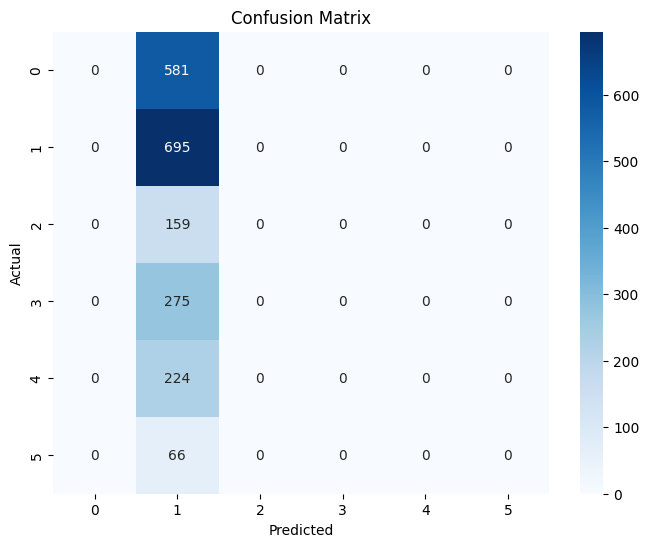

In [35]:
#Step 8: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
